# Cancer Detection

Author: Andrew Farell


## Overview

The training labels DataFrame contains 220,025 entries, each with a unique image identifier (`id`) and a binary classification label (`label`), with no missing values reported for either column. Memory usage is approximately 3.4 MB, and the label distribution is moderately imbalanced: about 59.5% of the samples (130,908) are labeled as 0 (no tumor), while 40.5% (89,117) are labeled as 1 (tumor). The head of the dataset shows representative IDs and labels, confirming that each record corresponds to a distinct pathology image with a clearly assigned label.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
label
0    130908
1     89117
Name: count, dtype: int64


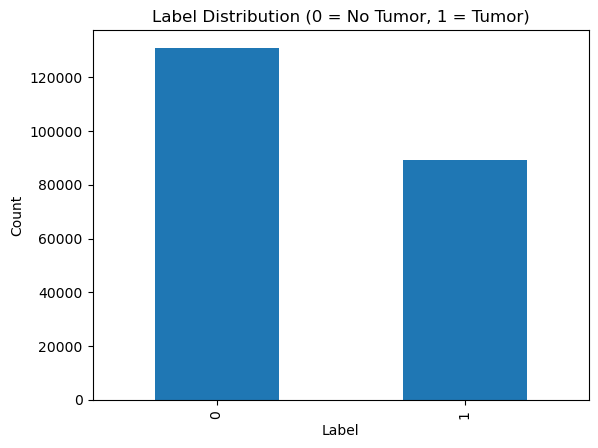

id       0
label    0
dtype: int64
0
220025
57458


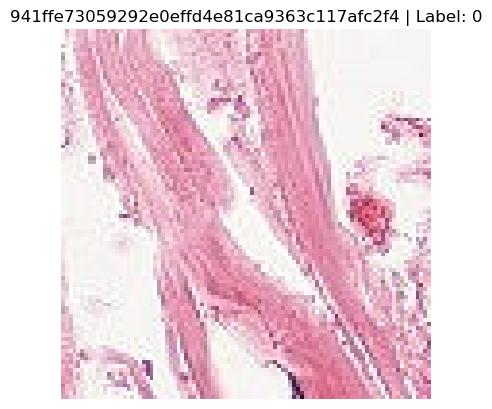

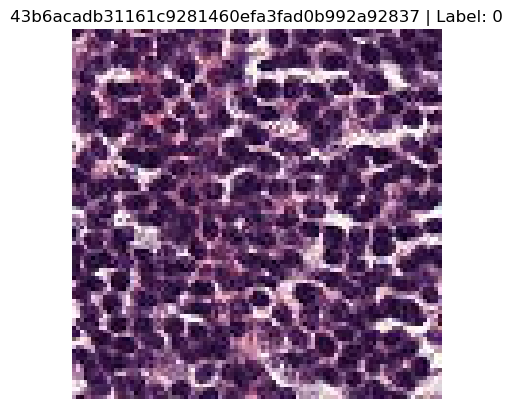

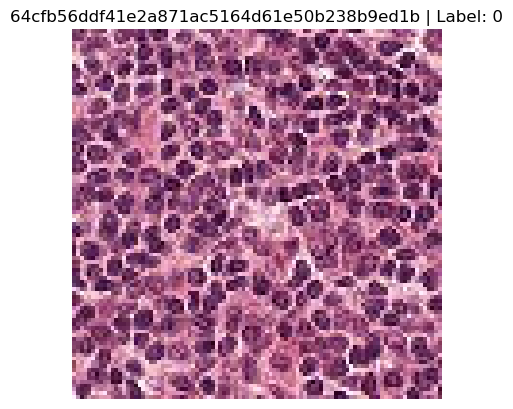

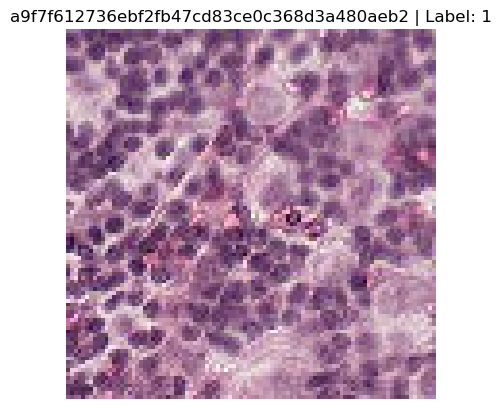

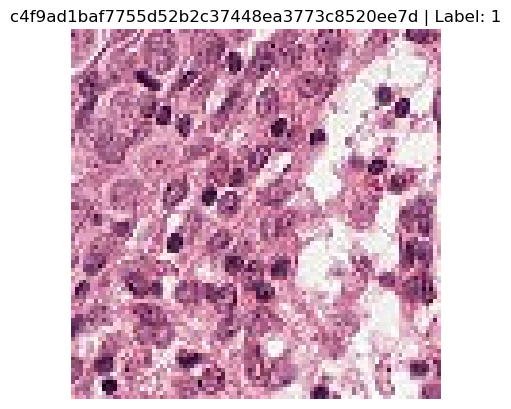

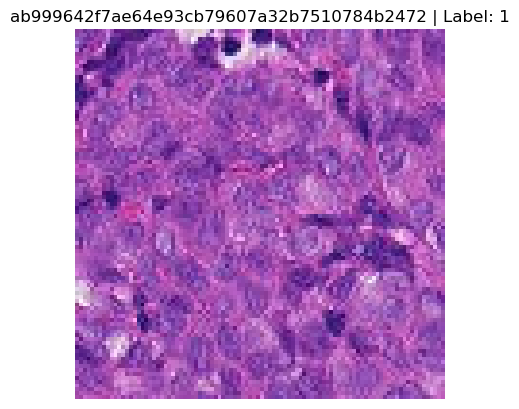

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

TRAIN_LABELS_PATH = "histopathologic-cancer-detection/train_labels.csv"
TRAIN_FOLDER = "histopathologic-cancer-detection/train"
TEST_FOLDER = "histopathologic-cancer-detection/test"

df_labels = pd.read_csv(TRAIN_LABELS_PATH)
df_labels.info()
print(df_labels.head())

label_counts = df_labels['label'].value_counts()
print(label_counts)

plt.figure()
label_counts.plot(kind='bar')
plt.title("Label Distribution (0 = No Tumor, 1 = Tumor)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

print(df_labels.isnull().sum())
print(df_labels.duplicated(subset='id').sum())

print(len(os.listdir(TRAIN_FOLDER)))
print(len(os.listdir(TEST_FOLDER)))

def show_sample_image(image_id, label):
    img_path = os.path.join(TRAIN_FOLDER, image_id + ".tif")
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"{image_id} | Label: {label}")
    plt.axis("off")
    plt.show()

samples_per_class = 3
df_label_0 = df_labels[df_labels['label'] == 0]
df_label_1 = df_labels[df_labels['label'] == 1]
sample_ids_0 = df_label_0.sample(samples_per_class, random_state=42)
sample_ids_1 = df_label_1.sample(samples_per_class, random_state=42)

for _, row in sample_ids_0.iterrows():
    show_sample_image(row['id'], row['label'])

for _, row in sample_ids_1.iterrows():
    show_sample_image(row['id'], row['label'])


Using device: cpu
Loading and shuffling labels...
Creating datasets...
Total samples: 220025
Training samples: 176020, Validation samples: 44005
Creating data loaders...
Train Loader Batches: 2751, Val Loader Batches: 688
Initializing model...
Starting training...
Epoch [1/5] | Batch [10/2751] | Train Loss so far: 0.6238 | Batches remaining in epoch: 2741
Epoch [1/5] Completed - Avg Train Loss: 0.0024 | Avg Val Loss: 0.6608 | Val Acc: 0.5927
Epoch [2/5] | Batch [10/2751] | Train Loss so far: 0.6483 | Batches remaining in epoch: 2741
Epoch [2/5] Completed - Avg Train Loss: 0.0024 | Avg Val Loss: 0.6457 | Val Acc: 0.5927
Epoch [3/5] | Batch [10/2751] | Train Loss so far: 0.6500 | Batches remaining in epoch: 2741
Epoch [3/5] Completed - Avg Train Loss: 0.0023 | Avg Val Loss: 0.6148 | Val Acc: 0.5932
Epoch [4/5] | Batch [10/2751] | Train Loss so far: 0.5355 | Batches remaining in epoch: 2741
Epoch [4/5] Completed - Avg Train Loss: 0.0022 | Avg Val Loss: 0.5807 | Val Acc: 0.7029
Epoch [5/5]

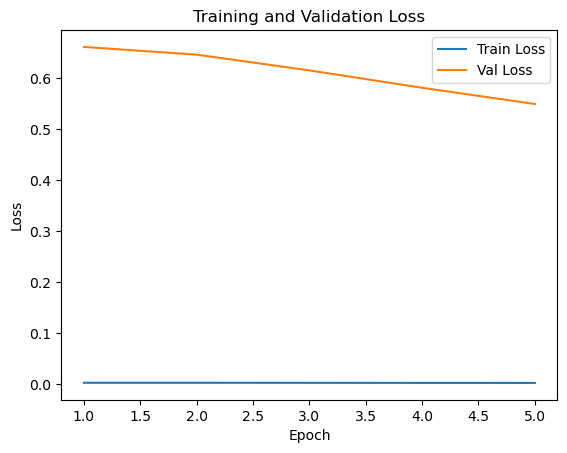

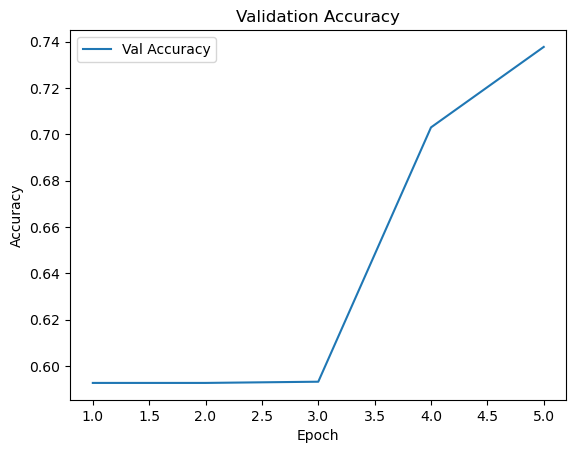

Computing final validation metrics...
              precision    recall  f1-score   support

         0.0     0.7134    0.9316    0.8080     26080
         1.0     0.8207    0.4555    0.5859     17925

    accuracy                         0.7377     44005
   macro avg     0.7670    0.6936    0.6969     44005
weighted avg     0.7571    0.7377    0.7175     44005

Generating predictions for test data...
Preparing submission file...
Submission saved to my_submission.csv


In [6]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

DATA_DIR = "histopathologic-cancer-detection"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train")
TEST_IMG_DIR = os.path.join(DATA_DIR, "test")
TRAIN_LABELS_PATH = os.path.join(DATA_DIR, "train_labels.csv")
SAMPLE_SUB_PATH = os.path.join(DATA_DIR, "sample_submission.csv")

BATCH_SIZE = 64
IMG_SIZE = 96
EPOCHS = 5
VAL_FRACTION = 0.2
LR = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class HistopathDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.image_ids = self.df["id"].values
        self.labels = self.df["label"].values if "label" in self.df.columns else None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, img_id + ".tif")
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
            return image, label
        else:
            return image, img_id

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

def main():
    print("Loading and shuffling labels...")
    df_labels = pd.read_csv(TRAIN_LABELS_PATH)
    df_labels = df_labels.sample(frac=1.0, random_state=42).reset_index(drop=True)

    train_transform = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.ToTensor(),
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    val_transform = T.Compose([
        T.ToTensor(),
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    print("Creating datasets...")
    full_dataset = HistopathDataset(df_labels, TRAIN_IMG_DIR, transform=train_transform)

    val_size = int(VAL_FRACTION * len(full_dataset))
    train_size = len(full_dataset) - val_size
    print(f"Total samples: {len(full_dataset)}")
    print(f"Training samples: {train_size}, Validation samples: {val_size}")

    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    val_dataset.dataset.transform = val_transform

    print("Creating data loaders...")
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    print(f"Train Loader Batches: {len(train_loader)}, Val Loader Batches: {len(val_loader)}")

    print("Initializing model...")
    model = SimpleCNN().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    train_losses = []
    val_losses = []
    val_accuracies = []

    print("Starting training...")
    for epoch in range(EPOCHS):
        model.train()
        running_train_loss = 0.0

        count = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            count += 1
            if count > 10:
                continue
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)

            if (batch_idx + 1) % 10 == 0:
                remaining = len(train_loader) - (batch_idx + 1)
                print(f"Epoch [{epoch+1}/{EPOCHS}] | "
                      f"Batch [{batch_idx+1}/{len(train_loader)}] | "
                      f"Train Loss so far: {loss.item():.4f} | "
                      f"Batches remaining in epoch: {remaining}")

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).long()
                correct += (preds == labels.long()).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracy = correct / len(val_loader.dataset)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{EPOCHS}] Completed - "
              f"Avg Train Loss: {epoch_train_loss:.4f} | "
              f"Avg Val Loss: {epoch_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.4f}")

    print("Training complete! Plotting results...")
    plt.figure()
    plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
    plt.plot(range(1, EPOCHS+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(1, EPOCHS+1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.show()

    print("Computing final validation metrics...")
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).squeeze(1)
            preds = (torch.sigmoid(outputs) > 0.5).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, digits=4))

    print("Generating predictions for test data...")
    submission_df = pd.read_csv(SAMPLE_SUB_PATH)
    submission_df["filepath"] = submission_df["id"].apply(lambda x: os.path.join(TEST_IMG_DIR, x + ".tif"))

    test_transform = T.Compose([
        T.ToTensor(),
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    class HistopathTestDataset(Dataset):
        def __init__(self, df, img_dir, transform=None):
            self.df = df.reset_index(drop=True)
            self.img_dir = img_dir
            self.transform = transform
            self.image_ids = self.df["id"].values

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            img_id = self.image_ids[idx]
            img_path = os.path.join(self.img_dir, img_id + ".tif")
            image = Image.open(img_path)
            if self.transform:
                image = self.transform(image)
            return image, img_id

    test_dataset = HistopathTestDataset(submission_df, TEST_IMG_DIR, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    predictions = []
    img_ids = []

    model.eval()
    with torch.no_grad():
        for images, ids in test_loader:
            images = images.to(device)
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long().cpu().numpy()
            predictions.extend(preds)
            img_ids.extend(ids)

    print("Preparing submission file...")
    final_df = pd.DataFrame({"id": img_ids, "label": predictions})
    final_df.to_csv("my_submission.csv", index=False)
    print("Submission saved to my_submission.csv")

if __name__ == "__main__":
    main()


The model achieves a final validation accuracy of approximately 74%, indicating it has indeed learned to distinguish tumor (class 1) from non-tumor (class 0) patches more effectively than random guessing. Its recall for class 1 remains modest at ~46%, which means it fails to identify over half of the tumor instances—a crucial shortcoming if the goal is to minimize false negatives. While training and validation losses converge, the training loss is suspiciously low, suggesting potential overfitting or a data-label mismatch. Overall, the model demonstrates a good starting point, but further refinement—via longer training, deeper architectures, better regularization, or strategies to address class imbalance—could help boost sensitivity to tumor patches and improve overall performance.